In [ ]:
# Auther: Tzu-Han Hsu

# BSD 3-Clause License

# Copyright (c) 2022, Anywhere Door Lab (ADL) and Tzu-Han Hsu
# All rights reserved.

# Redistribution and use in source and binary forms, with or without
# modification, are permitted provided that the following conditions are met:

# 1. Redistributions of source code must retain the above copyright notice, this
#    list of conditions and the following disclaimer.

# 2. Redistributions in binary form must reproduce the above copyright notice,
#    this list of conditions and the following disclaimer in the documentation
#    and/or other materials provided with the distribution.

# 3. Neither the name of the copyright holder nor the names of its
#    contributors may be used to endorse or promote products derived from
#    this software without specific prior written permission.

# THIS SOFTWARE IS PROVIDED BY THE COPYRIGHT HOLDERS AND CONTRIBUTORS "AS IS"
# AND ANY EXPRESS OR IMPLIED WARRANTIES, INCLUDING, BUT NOT LIMITED TO, THE
# IMPLIED WARRANTIES OF MERCHANTABILITY AND FITNESS FOR A PARTICULAR PURPOSE ARE
# DISCLAIMED. IN NO EVENT SHALL THE COPYRIGHT HOLDER OR CONTRIBUTORS BE LIABLE
# FOR ANY DIRECT, INDIRECT, INCIDENTAL, SPECIAL, EXEMPLARY, OR CONSEQUENTIAL
# DAMAGES (INCLUDING, BUT NOT LIMITED TO, PROCUREMENT OF SUBSTITUTE GOODS OR
# SERVICES; LOSS OF USE, DATA, OR PROFITS; OR BUSINESS INTERRUPTION) HOWEVER
# CAUSED AND ON ANY THEORY OF LIABILITY, WHETHER IN CONTRACT, STRICT LIABILITY,
# OR TORT (INCLUDING NEGLIGENCE OR OTHERWISE) ARISING IN ANY WAY OUT OF THE USE
# OF THIS SOFTWARE, EVEN IF ADVISED OF THE POSSIBILITY OF SUCH DAMAGE.

In [1]:
import torch
import torchvision 
import os
from torch.utils import data
from PIL import Image
import torchvision.datasets as dset
import numpy as np

import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
from tqdm.notebook import tqdm
import torchvision.models as models
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime
import matplotlib.pyplot as plt
import math
import pickle
from torchsummary import summary
from math import ceil
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#vital params



dataset_name="cifar10"
 
model_name="EfficientNetb0_sp"
version = "b0"

base_model = [
    # expand_ratio, channels, repeats, stride, kernel_size
    [1, 16, 1, 1, 3],
    [6, 24, 2, 2, 3],
    [6, 40, 2, 2, 5],
    [6, 80, 3, 2, 3],
    [6, 112, 3, 1, 5],
    [6, 192, 4, 2, 5],
    [6, 320, 1, 1, 3],
]

phi_values = {
    # tuple of: (phi_value, resolution, drop_rate)
    "b0": (0, 224, 0.2),  # alpha, beta, gamma, depth = alpha ** phi
    "b1": (0.5, 240, 0.2),
    "b2": (1, 260, 0.3),
    "b3": (2, 300, 0.3),
    "b4": (3, 380, 0.4),
    "b5": (4, 456, 0.4),
    "b6": (5, 528, 0.5),
    "b7": (6, 600, 0.5),
}

phi, res, drop_rate = phi_values[version]
#hyperparameters
batch_size=20
num_classes=-1
learning_rate=0.001
image_size=(res,res)

if dataset_name == "tsrd":
    num_classes=58
elif dataset_name == "cifar10":
    num_classes=10


print("Model: "+model_name +" with {} classes".format(num_classes)+
      " running on: "+dataset_name)
print("The input image size is:{}".format(image_size))

Model: EfficientNetb0_sp with 10 classes running on: cifar10
The input image size is:(224, 224)


In [2]:
# load data through imagefolder
if dataset_name == "tsrd":
    main_transforms=transforms.Compose([
        transforms.Resize(image_size),
        transforms.ToTensor(),
        transforms.Normalize(mean = [0.485, 0.456, 0.406] , std = [0.229, 0.224, 0.225]),

    ])

    train_dir = "../../dataset/data"
    head_train_set = dset.ImageFolder(train_dir,transform=main_transforms)
    train_set, valid_set = data.random_split(head_train_set, [5000, 998])
    train_set, test_set = data.random_split(train_set,[4000, 1000])


    train_dataloader=torch.utils.data.DataLoader(train_set,
                                                 batch_size=batch_size,
                                                 shuffle=True)

    val_dataloader=torch.utils.data.DataLoader(valid_set,
                                                 batch_size=batch_size,
                                                 shuffle=True)

    test_dataloader=torch.utils.data.DataLoader(test_set,
                                                 batch_size=1,
                                                 shuffle=True)
    print(head_train_set.class_to_idx)
elif dataset_name == "cifar10":
    
    main_transforms=transforms.Compose([
        transforms.Resize(image_size),
        transforms.ToTensor(),
        transforms.Normalize(mean = [0.5, 0.5, 0.5] , std = [0.5, 0.5, 0.5]),

    ])

    bigtrain_set = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=main_transforms)
    train_set, valid_set = data.random_split(bigtrain_set, [40000, 10000])
    test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=main_transforms)


    train_dataloader = torch.utils.data.DataLoader(train_set, 
                                                   batch_size=batch_size, 
                                                   shuffle=True, num_workers=2)

    val_dataloader = torch.utils.data.DataLoader(valid_set, 
                                                   batch_size=batch_size, 
                                                   shuffle=True, num_workers=2)

    test_dataloader = torch.utils.data.DataLoader(test_set,
                                                  batch_size=batch_size,
                                                  shuffle=False, num_workers=2)
    





print("Dataset size: Train: {}, Valid: {}, Test: {}"
      .format(len(train_set),len(valid_set),len(test_set)))


print(train_set[0][0].shape)
print("Datasets loaded and prepared")

Files already downloaded and verified
Files already downloaded and verified
Dataset size: Train: 40000, Valid: 10000, Test: 10000
torch.Size([3, 224, 224])
Datasets loaded and prepared


In [3]:
class CNNBlock(nn.Module):
    def __init__(
            self, in_channels, out_channels, kernel_size, stride, padding, groups=1
    ):
        super(CNNBlock, self).__init__()
        self.cnn = nn.Conv2d(
            in_channels,
            out_channels,
            kernel_size,
            stride,
            padding,
            groups=groups,
            bias=False,
        )
        self.bn = nn.BatchNorm2d(out_channels)
        self.silu = nn.SiLU() # SiLU <-> Swish

    def forward(self, x):
        return self.silu(self.bn(self.cnn(x)))

class SqueezeExcitation(nn.Module):
    def __init__(self, in_channels, reduced_dim):
        super(SqueezeExcitation, self).__init__()
        self.se = nn.Sequential(
            nn.AdaptiveAvgPool2d(1), # C x H x W -> C x 1 x 1
            nn.Conv2d(in_channels, reduced_dim, 1),
            nn.SiLU(),
            nn.Conv2d(reduced_dim, in_channels, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        return x * self.se(x)

class InvertedResidualBlock(nn.Module):
    def __init__(
            self,
            in_channels,
            out_channels,
            kernel_size,
            stride,
            padding,
            expand_ratio,
            reduction=4, # squeeze excitation
            survival_prob=0.8, # for stochastic depth
    ):
        super(InvertedResidualBlock, self).__init__()
        self.survival_prob = 0.8
        self.use_residual = in_channels == out_channels and stride == 1
        hidden_dim = in_channels * expand_ratio
        self.expand = in_channels != hidden_dim
        reduced_dim = int(in_channels / reduction)

        if self.expand:
            self.expand_conv = CNNBlock(
                in_channels, hidden_dim, kernel_size=3, stride=1, padding=1,
            )

        self.conv = nn.Sequential(
            CNNBlock(
                hidden_dim, hidden_dim, kernel_size, stride, padding, groups=hidden_dim,
            ),
            SqueezeExcitation(hidden_dim, reduced_dim),
            nn.Conv2d(hidden_dim, out_channels, 1, bias=False),
            nn.BatchNorm2d(out_channels),
        )

    def stochastic_depth(self, x):
        if not self.training:
            return x

        binary_tensor = torch.rand(x.shape[0], 1, 1, 1, device=x.device) < self.survival_prob
        return torch.div(x, self.survival_prob) * binary_tensor

    def forward(self, inputs):
        x = self.expand_conv(inputs) if self.expand else inputs

        if self.use_residual:
            return self.stochastic_depth(self.conv(x)) + inputs
        else:
            return self.conv(x)


class EfficientNet(nn.Module):
    def __init__(self, version, num_classes):
        super(EfficientNet, self).__init__()
        width_factor, depth_factor, dropout_rate = self.calculate_factors(version)
        last_channels = ceil(1280 * width_factor)
        self.localization = nn.Sequential(
            nn.Conv2d(3, 8, kernel_size=7),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True),
            nn.Conv2d(8, 10, kernel_size=5),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True)
        )

        # Regressor for the 3 * 2 affine matrix
        self.fc_loc = nn.Sequential(
            nn.Linear(27040, 32),
            nn.ReLU(True),
            nn.Linear(32, 3 * 2)
        )
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.features = self.create_features(width_factor, depth_factor, last_channels)
        self.classifier = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(last_channels, num_classes),
        )
        


        # Initialize the weights/bias with identity transformation
        self.fc_loc[2].weight.data.zero_()
        self.fc_loc[2].bias.data.copy_(torch.tensor([1, 0, 0, 0, 1, 0], dtype=torch.float))

    # Spatial transformer network forward function
    def stn(self, x):

        xs = self.localization(x)

        xs = xs.view(-1, 10 * 52 * 52)
        theta = self.fc_loc(xs)
        theta = theta.view(-1, 2, 3)
        grid = F.affine_grid(theta, x.size())
        x = F.grid_sample(x, grid)
        
        
    def calculate_factors(self, version, alpha=1.2, beta=1.1):
        phi, res, drop_rate = phi_values[version]
        depth_factor = alpha ** phi
        width_factor = beta ** phi
        return width_factor, depth_factor, drop_rate

    def create_features(self, width_factor, depth_factor, last_channels):
        channels = int(32 * width_factor)
        features = [CNNBlock(3, channels, 3, stride=2, padding=1)]
        in_channels = channels

        for expand_ratio, channels, repeats, stride, kernel_size in base_model:
            out_channels = 4*ceil(int(channels*width_factor) / 4)
            layers_repeats = ceil(repeats * depth_factor)

            for layer in range(layers_repeats):
                features.append(
                    InvertedResidualBlock(
                        in_channels,
                        out_channels,
                        expand_ratio=expand_ratio,
                        stride = stride if layer == 0 else 1,
                        kernel_size=kernel_size,
                        padding=kernel_size//2, # if k=1:pad=0, k=3:pad=1, k=5:pad=2
                    )
                )
                in_channels = out_channels

        features.append(
            CNNBlock(in_channels, last_channels, kernel_size=1, stride=1, padding=0)
        )

        return nn.Sequential(*features)

    def forward(self, x):
        self.stn(x)
        x = self.pool(self.features(x))
        
        return self.classifier(x.view(x.shape[0], -1))


def test():
    device = "cuda" if torch.cuda.is_available() else "cpu"
    version = "b0"
    phi, res, drop_rate = phi_values[version]
    num_examples = 4
    x = torch.randn((num_examples, 3, res, res)).to(device)
    model = EfficientNet(
        version=version,
        num_classes=num_classes,
    ).to(device)
    print(x.shape)
    print(model(x).shape) # (num_examples, num_classes)

test()



torch.Size([4, 3, 224, 224])
torch.Size([4, 10])


C:\Users\2080Ti\Anaconda3\envs\pytorch\lib\site-packages\torch\nn\functional.py:4044: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "
C:\Users\2080Ti\Anaconda3\envs\pytorch\lib\site-packages\torch\nn\functional.py:3982: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "


In [4]:
model = EfficientNet(
    version=version,
    num_classes=num_classes,
).to(device)

model = model.to(device)

from thop import profile
import colorama
from colorama import Fore,Style
#vital params
def getGFLOPS(test_model):
    model=test_model.to(device)
    input = torch.randn(1, 3, 224, 224).to(device)
    macs, params = profile(model, inputs=(input, ))

    print(Fore.BLUE + "The model requires: {:.4f} GFLOPS".format(macs/1000_000_000))
    print(Style.RESET_ALL)
    return macs
getGFLOPS(model)

#pretesting model for shape
x=torch.randn(64,3,res,res)
x=x.to(device)
print(x.shape)
print(model(x).shape)
print(summary(model, input_size=(3, res, res)))
print("model shape ready")

#initailise network


#loss and optimizer
criterion=nn.CrossEntropyLoss()
optimizer=optim.Adam(model.parameters(),lr=learning_rate)

print("model initialised")

[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.pooling.MaxPool2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU'>.
[WARN] Cannot find rule for <class 'torch.nn.modules.container.Sequential'>. Treat it as zero Macs and zero Params.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[INFO] Register count_adap_avgpool() for <class 'torch.nn.modules.pooling.AdaptiveAvgPool2d'>.
[INFO] Register count_bn() for <class 'torch.nn.modules.batchnorm.BatchNorm2d'>.
[WARN] Cannot find rule for <class 'torch.nn.modules.activation.SiLU'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class '__main__.CNNBlock'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.modules.activation.Sigmoid'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class '__main__.SqueezeExcitation'>. Treat it as zero 

C:\Users\2080Ti\Anaconda3\envs\pytorch\lib\site-packages\torch\_tensor.py:575: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  ..\aten\src\ATen\native\BinaryOps.cpp:467.)
  return torch.floor_divide(self, other)


torch.Size([64, 10])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 8, 218, 218]           1,184
         MaxPool2d-2          [-1, 8, 109, 109]               0
              ReLU-3          [-1, 8, 109, 109]               0
            Conv2d-4         [-1, 10, 105, 105]           2,010
         MaxPool2d-5           [-1, 10, 52, 52]               0
              ReLU-6           [-1, 10, 52, 52]               0
            Linear-7                   [-1, 32]         865,312
              ReLU-8                   [-1, 32]               0
            Linear-9                    [-1, 6]             198
           Conv2d-10         [-1, 32, 112, 112]             864
      BatchNorm2d-11         [-1, 32, 112, 112]              64
             SiLU-12         [-1, 32, 112, 112]               0
         CNNBlock-13         [-1, 32, 112, 112]               0
           Conv2d-

In [6]:
# This is the testing part
def get_n_params(model):
    pp=0
    for p in list(model.parameters()):
        nn=1
        for s in list(p.size()):
            nn = nn*s
        pp += nn
    return pp
get_n_params(model)

def test(model, test_loader, istest= False, doprint=True):
    model.eval()
    test_loss = 0
    correct = 0
    TP=0
    TN=0
    FN=0
    FP=0
    test_loss = 0.0
    
    with torch.no_grad(): # disable gradient calculation for efficiency
        for data, target in tqdm(test_loader):
            # Prediction
            data=data.to(device=device)
            target=target.to(device=device)
            optimizer.zero_grad()
            
            output = model(data)
            loss=criterion(output,target)
            
            # Compute loss & accuracy
            test_loss+=loss.item()*data.size(0)

            
            #test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item() # how many predictions in this batch are correct
            
            #print("pred={} , target={} , judge={}".format(pred.item(),target.item(),pred.eq(target.view_as(pred)).sum().item()))

            
    #test_loss /= len(test_loader.dataset)

        
    # Log testing info
    if istest and doprint:
        
        print('Loss: {}   Accuracy: {}/{} ({:.3f}%)'.format(test_loss,
        correct, len(test_loader.dataset),
        100.000 * correct / len(test_loader.dataset)))
        print("Total parameters: {}".format(get_n_params(model)))
    elif doprint:
        print('Accuracy: {}/{} ({:.3f}%)'.format(
        correct, len(test_loader.dataset),
        100.000 * correct / len(test_loader.dataset)))
    return 100.000 * correct / len(test_loader.dataset)
        

print("test defined")

def testshouldearlystop(acclist,minepoch,epochwindow,accwindow):
    runlen=len(acclist)
    if(runlen<minepoch):
        return False
    elif(acclist[-1]>acclist[-2]):
        return False
    
    watchwindow=acclist[-epochwindow:]
    shouldjump=True
    sum=0
    for i in watchwindow:
        sum+=i
    avg = sum/epochwindow
    for i in watchwindow:
        if abs(i-avg)>(accwindow):
            shouldjump=False
    return shouldjump
print("early stop defined")

test defined
early stop defined


In [7]:
now=datetime.now()
dt_string = now.strftime("%Y%m%d%H%M%S")

tensorboard_string="runs/"+model_name+dt_string
grandstore_string="grandstore/"+dataset_name+"_"+model_name+dt_string+".pkl"
print("tensorboard_string:")
print(tensorboard_string)
print("grandstore_string:")
print(grandstore_string)


writer = SummaryWriter(tensorboard_string)


tensorboard_string:
runs/EfficientNetb0_sp20211025201859
grandstore_string:
grandstore/cifar10_EfficientNetb0_sp20211025201859.pkl


In [8]:
#This is the training part

# Grand_store={
#     'total_epoch_run':-1
#     'topmodels':-1
#     'lastmodel':-1
#     'acclog':[]
#     'maxacc':-1
#     'minacc':101
# }
# train_epoch={
#     "numofepoch":-1
#     "accuracy":-1
#     "model_state":model.state_dict(),
#     "optim_state":optimizer.state_dict(),
#     "totaltrain_loss":totaltrain_loss,
#     "totalvalid_loss":totalvalid_loss
# }

def training(max_epoch=120, top_accuracy_track=3, grandstore={},
             minepoch=30,epochwindow=10,accwindow=0.35):

    grandstore['total_epoch_run']=0
    grandstore['topmodels']=[]
    grandstore['acclog']=[]
    grandstore['maxacc']=-1
    grandstore['minacc']=101
    
    for epoch in range(0,max_epoch):
        
        grandstore['total_epoch_run']=epoch+1
        
        train_epoch={
        "numofepoch":grandstore['total_epoch_run']
        }
    
        train_loss=0.0
        valid_loss=0.0
        print("Running epoch: {}".format(epoch+1))

        model.train()
        totaltrain_loss=0
        
        #this is the training part
        for data,target in tqdm(train_dataloader):
            data=data.to(device=device)
            target=target.to(device=device)
            output = model(data)
            loss = criterion(output, target)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item()*data.size(0)
            totaltrain_loss += train_loss

        #this is the validation part
        model.eval()
        totalvalid_loss=0;
        correct = 0
        for data,target in tqdm(val_dataloader):
            data=data.to(device=device)
            target=target.to(device=device)
            output=model(data)
            loss=criterion(output,target)
            valid_loss=loss.item()*data.size(0)
            #train_loss = train_loss/len(train_dataloader.dataset)
            #valid_loss = valid_loss/len(val_dataloader.dataset)
            totalvalid_loss+=valid_loss
            
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item() # how many predictions in t
        

        training_accuracy=100. * correct / len(val_dataloader.dataset)
        train_epoch["accuracy"]=training_accuracy
        train_epoch["totaltrain_loss"]=totaltrain_loss
        train_epoch["totalvalid_loss"]=totalvalid_loss
        
        #writings to the GrandStore
        
        grandstore['acclog'].append(training_accuracy)
        
        if training_accuracy < grandstore['minacc']:
            grandstore['minacc'] = training_accuracy
            
        if training_accuracy > grandstore['maxacc']:
            grandstore['maxacc'] = training_accuracy
        

        if epoch < top_accuracy_track:
            thisepochtestresult=test(model,test_dataloader,istest = True,doprint=False)
            grandstore['topmodels'].append((training_accuracy,thisepochtestresult,epoch+1,train_epoch))
            #if error print this
            grandstore['topmodels'].sort()

        elif training_accuracy > grandstore['topmodels'][0][0]:
            thisepochtestresult=test(model,test_dataloader,istest = True,doprint=False)
            grandstore['topmodels'][0]=(training_accuracy,thisepochtestresult,epoch+1,train_epoch)
            #if error print this
            grandstore['topmodels'].sort()

        if epoch == (max_epoch-1):
            thisepochtestresult=test(model,test_dataloader,istest = True,doprint=False)
            grandstore['lastmodel']=(training_accuracy,thisepochtestresult,epoch+1,train_epoch)
                     
        writer.add_scalar('Training Loss',totaltrain_loss,global_step = epoch)
        writer.add_scalar('Valid Loss',totalvalid_loss,global_step = epoch)
        writer.add_scalar('Accuracy',training_accuracy,global_step = epoch)
        
        print('Accuracy: {:.3f}'.format(training_accuracy))
        print('Training Loss: {:.4f} \tValidation Loss: {:.4f}\n'.format(totaltrain_loss, totalvalid_loss))
        
        #early stopping criteria
        if(testshouldearlystop(acclist=grandstore['acclog'],
                               minepoch = minepoch,
                               epochwindow = epochwindow,
                               accwindow = accwindow)):
            print("early stop occured!!")
            thisepochtestresult=test(model,test_dataloader,istest = True,doprint=False)
            grandstore['lastmodel']=(training_accuracy,thisepochtestresult,epoch+1,train_epoch)
            return grandstore
    
    return grandstore
        


In [9]:
TOP_ACCURACY_TRACK = 5
# max_epoch=120, top_accuracy_track=3, grandstore={},
# minepoch=30,epochwindow=10,accwindow=0.35

Grandstore=training(max_epoch=120,
                    minepoch=30,
                    top_accuracy_track=TOP_ACCURACY_TRACK,
                    epochwindow=10,
                    accwindow=0.25                  
                   )

Running epoch: 1


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 56.990
Training Loss: 70279619.0987 	Validation Loss: 12016.8370

Running epoch: 2


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 70.140
Training Loss: 45004431.7043 	Validation Loss: 8503.7407

Running epoch: 3


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 75.950
Training Loss: 33883889.0889 	Validation Loss: 6993.3353

Running epoch: 4


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 77.320
Training Loss: 27408587.0632 	Validation Loss: 6502.7013

Running epoch: 5


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 80.060
Training Loss: 23506518.7221 	Validation Loss: 5769.3573

Running epoch: 6


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 82.380
Training Loss: 19936968.7326 	Validation Loss: 5198.4660

Running epoch: 7


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 83.460
Training Loss: 17073562.2853 	Validation Loss: 4936.0037

Running epoch: 8


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 83.750
Training Loss: 14689622.7312 	Validation Loss: 5127.7201

Running epoch: 9


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 83.250
Training Loss: 12727419.3897 	Validation Loss: 5182.1985

Running epoch: 10


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 84.570
Training Loss: 10333797.2484 	Validation Loss: 4892.5937

Running epoch: 11


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.420
Training Loss: 8776704.5600 	Validation Loss: 4867.3144

Running epoch: 12


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 84.730
Training Loss: 7487708.3236 	Validation Loss: 5199.5138

Running epoch: 13


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.100
Training Loss: 6655855.4567 	Validation Loss: 5386.1934

Running epoch: 14


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.010
Training Loss: 5892538.3565 	Validation Loss: 5442.6248

Running epoch: 15


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 84.800
Training Loss: 5173352.7414 	Validation Loss: 5950.0676

Running epoch: 16


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.390
Training Loss: 4757164.6413 	Validation Loss: 5848.6000

Running epoch: 17


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 84.450
Training Loss: 4320954.5758 	Validation Loss: 6347.4257

Running epoch: 18


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 84.500
Training Loss: 3965749.1904 	Validation Loss: 6365.4198

Running epoch: 19


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 84.710
Training Loss: 3415299.6238 	Validation Loss: 6170.7722

Running epoch: 20


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.180
Training Loss: 3243361.3174 	Validation Loss: 6249.8743

Running epoch: 21


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.080
Training Loss: 2890639.1017 	Validation Loss: 6345.2192

Running epoch: 22


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.180
Training Loss: 2936155.7914 	Validation Loss: 6663.7308

Running epoch: 23


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.570
Training Loss: 2787972.0326 	Validation Loss: 6369.0669

Running epoch: 24


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.770
Training Loss: 2903932.2571 	Validation Loss: 6188.9227

Running epoch: 25


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.480
Training Loss: 2381981.8102 	Validation Loss: 6707.7525

Running epoch: 26


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.630
Training Loss: 2465888.4657 	Validation Loss: 7133.9422

Running epoch: 27


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.330
Training Loss: 2448542.2374 	Validation Loss: 6823.0765

Running epoch: 28


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.610
Training Loss: 2381797.5817 	Validation Loss: 6616.7113

Running epoch: 29


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.400
Training Loss: 2080910.1013 	Validation Loss: 6712.8780

Running epoch: 30


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 84.970
Training Loss: 2202285.5807 	Validation Loss: 6952.3347

Running epoch: 31


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.930
Training Loss: 1854507.8657 	Validation Loss: 6957.5517

Running epoch: 32


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.610
Training Loss: 1944623.4341 	Validation Loss: 7115.6223

Running epoch: 33


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.270
Training Loss: 1778271.5328 	Validation Loss: 7002.9562

Running epoch: 34


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.580
Training Loss: 1617760.2596 	Validation Loss: 7293.0514

Running epoch: 35


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.710
Training Loss: 1793424.4149 	Validation Loss: 7460.7230

Running epoch: 36


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.820
Training Loss: 1503135.4303 	Validation Loss: 7157.9181

Running epoch: 37


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.600
Training Loss: 1738071.1572 	Validation Loss: 7141.6065

Running epoch: 38


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 84.870
Training Loss: 1618409.0506 	Validation Loss: 7645.2918

Running epoch: 39


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 84.930
Training Loss: 1646914.8273 	Validation Loss: 7870.1484

Running epoch: 40


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.710
Training Loss: 1618847.2576 	Validation Loss: 7193.6852

Running epoch: 41


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.480
Training Loss: 1468428.4750 	Validation Loss: 7820.1680

Running epoch: 42


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.750
Training Loss: 1485342.8868 	Validation Loss: 7232.6254

Running epoch: 43


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.550
Training Loss: 1404640.4395 	Validation Loss: 7509.6589

Running epoch: 44


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.880
Training Loss: 1479500.7856 	Validation Loss: 7609.9203

Running epoch: 45


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.820
Training Loss: 1443302.4892 	Validation Loss: 7717.3006

Running epoch: 46


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.270
Training Loss: 1280191.0743 	Validation Loss: 6965.6624

Running epoch: 47


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.280
Training Loss: 1289942.8214 	Validation Loss: 7745.8804

Running epoch: 48


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.830
Training Loss: 1308993.4864 	Validation Loss: 7442.4693

Running epoch: 49


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.710
Training Loss: 1057489.5823 	Validation Loss: 7378.8135

Running epoch: 50


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.700
Training Loss: 1111354.6270 	Validation Loss: 7233.4088

Running epoch: 51


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.720
Training Loss: 1266425.4844 	Validation Loss: 7354.4098

Running epoch: 52


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.890
Training Loss: 1291912.0365 	Validation Loss: 7600.7921

Running epoch: 53


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.580
Training Loss: 1079290.5326 	Validation Loss: 7803.7465

Running epoch: 54


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.840
Training Loss: 1148671.6209 	Validation Loss: 7256.1431

Running epoch: 55


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.360
Training Loss: 968980.1879 	Validation Loss: 7331.0401

Running epoch: 56


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.460
Training Loss: 1066291.9718 	Validation Loss: 7328.0074

Running epoch: 57


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.560
Training Loss: 1074392.7464 	Validation Loss: 7763.6045

Running epoch: 58


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.810
Training Loss: 969564.7122 	Validation Loss: 7925.0573

Running epoch: 59


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.760
Training Loss: 1046646.9582 	Validation Loss: 7766.0422

Running epoch: 60


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.370
Training Loss: 848777.3893 	Validation Loss: 7673.3049

Running epoch: 61


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.880
Training Loss: 1184557.8229 	Validation Loss: 8529.0672

Running epoch: 62


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.080
Training Loss: 918198.9365 	Validation Loss: 7868.3059

Running epoch: 63


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.490
Training Loss: 886136.3062 	Validation Loss: 8223.5188

Running epoch: 64


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.410
Training Loss: 945929.8907 	Validation Loss: 7760.1399

Running epoch: 65


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.790
Training Loss: 886383.1677 	Validation Loss: 7813.2542

Running epoch: 66


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 87.030
Training Loss: 1034508.4964 	Validation Loss: 7443.7213

Running epoch: 67


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.680
Training Loss: 909918.5600 	Validation Loss: 7873.9965

Running epoch: 68


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.440
Training Loss: 797182.3158 	Validation Loss: 7699.4267

Running epoch: 69


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.950
Training Loss: 1048402.8301 	Validation Loss: 7965.1871

Running epoch: 70


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.220
Training Loss: 717183.2652 	Validation Loss: 8098.7518

Running epoch: 71


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.640
Training Loss: 742970.4834 	Validation Loss: 7926.7577

Running epoch: 72


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.640
Training Loss: 868820.6550 	Validation Loss: 7789.3531

Running epoch: 73


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.480
Training Loss: 759134.0321 	Validation Loss: 7596.1453

Running epoch: 74


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.530
Training Loss: 705085.0483 	Validation Loss: 7817.7652

Running epoch: 75


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.410
Training Loss: 956817.1059 	Validation Loss: 8149.5537

Running epoch: 76


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.250
Training Loss: 808928.1428 	Validation Loss: 7573.8802

Running epoch: 77


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.450
Training Loss: 827024.2550 	Validation Loss: 7967.6526

Running epoch: 78


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.720
Training Loss: 866504.9519 	Validation Loss: 7879.7842

Running epoch: 79


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.540
Training Loss: 719564.1155 	Validation Loss: 8095.6552

Running epoch: 80


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.560
Training Loss: 770889.5065 	Validation Loss: 7882.8042

Running epoch: 81


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.400
Training Loss: 721001.8295 	Validation Loss: 8639.4633

Running epoch: 82


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.660
Training Loss: 766984.1810 	Validation Loss: 7569.0688

Running epoch: 83


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.910
Training Loss: 627665.9251 	Validation Loss: 8332.3733

Running epoch: 84


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.870
Training Loss: 811068.2381 	Validation Loss: 8540.4560

Running epoch: 85


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.100
Training Loss: 780287.3121 	Validation Loss: 8191.2378

Running epoch: 86


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.630
Training Loss: 790014.7918 	Validation Loss: 7835.0252

Running epoch: 87


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.890
Training Loss: 784917.6889 	Validation Loss: 8210.8624

Running epoch: 88


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.410
Training Loss: 724438.9313 	Validation Loss: 8293.9803

Running epoch: 89


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.710
Training Loss: 847829.4307 	Validation Loss: 7717.9701

Running epoch: 90


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.250
Training Loss: 639621.8694 	Validation Loss: 7911.1462

Running epoch: 91


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.600
Training Loss: 827419.7271 	Validation Loss: 8939.5992

Running epoch: 92


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.590
Training Loss: 640487.9243 	Validation Loss: 8068.7535

Running epoch: 93


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.120
Training Loss: 699453.8112 	Validation Loss: 8322.4674

Running epoch: 94


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.380
Training Loss: 773257.4713 	Validation Loss: 8349.1305

Running epoch: 95


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.160
Training Loss: 603384.8873 	Validation Loss: 8279.4226

Running epoch: 96


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.520
Training Loss: 731633.1015 	Validation Loss: 7821.8556

Running epoch: 97


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 87.160
Training Loss: 619971.3394 	Validation Loss: 7978.0545

Running epoch: 98


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 87.120
Training Loss: 676087.9074 	Validation Loss: 7722.5746

Running epoch: 99


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 87.020
Training Loss: 605748.7422 	Validation Loss: 8095.7186

Running epoch: 100


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.730
Training Loss: 654352.3576 	Validation Loss: 8641.9368

Running epoch: 101


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.620
Training Loss: 739207.6588 	Validation Loss: 7988.4644

Running epoch: 102


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.050
Training Loss: 456093.7865 	Validation Loss: 8768.0387

Running epoch: 103


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 87.190
Training Loss: 598531.9902 	Validation Loss: 8008.3943

Running epoch: 104


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.970
Training Loss: 725926.4641 	Validation Loss: 8025.9071

Running epoch: 105


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.850
Training Loss: 494736.5357 	Validation Loss: 8149.9732

Running epoch: 106


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.660
Training Loss: 695952.2654 	Validation Loss: 8286.3661

Running epoch: 107


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.930
Training Loss: 565043.9823 	Validation Loss: 8964.9023

Running epoch: 108


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.040
Training Loss: 623319.8595 	Validation Loss: 8476.0436

Running epoch: 109


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.450
Training Loss: 549774.5321 	Validation Loss: 8639.8266

Running epoch: 110


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.520
Training Loss: 558096.0055 	Validation Loss: 8112.2266

Running epoch: 111


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.340
Training Loss: 592185.0148 	Validation Loss: 9508.3776

Running epoch: 112


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.330
Training Loss: 405766.7691 	Validation Loss: 9173.5298

Running epoch: 113


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.210
Training Loss: 635167.7328 	Validation Loss: 9243.0454

Running epoch: 114


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.590
Training Loss: 547107.3784 	Validation Loss: 9157.9001

Running epoch: 115


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.420
Training Loss: 620984.7041 	Validation Loss: 8822.0911

Running epoch: 116


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.310
Training Loss: 514726.4159 	Validation Loss: 8651.2305

Running epoch: 117


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.580
Training Loss: 645061.1775 	Validation Loss: 8779.0548

Running epoch: 118


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.020
Training Loss: 452014.5433 	Validation Loss: 8865.1028

Running epoch: 119


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 87.480
Training Loss: 613179.6295 	Validation Loss: 8233.8590

Running epoch: 120


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 87.130
Training Loss: 626327.5854 	Validation Loss: 8287.7579



Total Run 120 epoch(s)
Accuracy MIN: 56.99 / MAX: 87.48

Top 5 performing epochs:
#1 epoch 119	||train_acc 87.48%	||test 85.95%
#2 epoch 103	||train_acc 87.19%	||test 85.79%
#3 epoch 97	||train_acc 87.16%	||test 86.4%
#4 epoch 120	||train_acc 87.13%	||test 86.29%
#5 epoch 98	||train_acc 87.12%	||test 86.33%

Last epoch:
epoch 120	||train_acc 87.13%	||test 86.29%

The model has parameters: 14916070


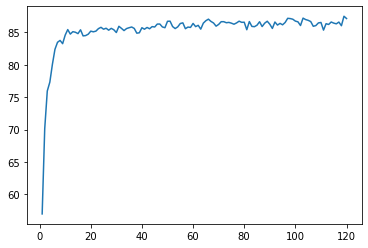

In [12]:
print("Total Run {} epoch(s)".format(Grandstore['total_epoch_run']))

plt.plot(*[range(1,Grandstore['total_epoch_run']+1)],Grandstore['acclog'])
print("Accuracy MIN: {} / MAX: {}".format(Grandstore['minacc'],Grandstore['maxacc']))
print()
print("Top {} performing epochs:".format(TOP_ACCURACY_TRACK))


gstm=Grandstore['topmodels']
for i in range(TOP_ACCURACY_TRACK):
    easy=gstm[TOP_ACCURACY_TRACK-i-1]
    print("#{} epoch {}\t||train_acc {}%\t||test {}%".format(i+1,easy[2],easy[0],easy[1]))
print()
print("Last epoch:")
lsmd=Grandstore['lastmodel']
print("epoch {}\t||train_acc {}%\t||test {}%".format(Grandstore['total_epoch_run'],lsmd[0],lsmd[1]))
      
print()
print("The model has parameters: {}".format(get_n_params(model)))
#grandstore['lastmodel']=((training_accuracy,train_epoch,thisepochtestresult))
# grandstore['lastmodel']=(training_accuracy,thisepochtestresult,epoch+1,train_epoch)

In [13]:
  
f1=open(grandstore_string,"wb")
pickle.dump(Grandstore,f1)
f1.close()

print("writings done!")
print("Files at: "+grandstore_string)

# with open(grandstore_string, 'rb') as file:
#     myvar = pickle.load(file)
#     print(myvar)

writings done!
Files at: grandstore/cifar10_EfficientNetb0_sp20211025201859.pkl
